# Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Global variables

In [2]:
img_folder = './Images/'
img_names = os.listdir(img_folder)

In [3]:
shapes = [cv2.imread(img_folder+i).shape for i in img_names]

In [4]:
cross_kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], np.uint8)
h_line_kernel = np.array([[0,0,0],[1,1,1],[0,0,0]], np.uint8)
v_line_kernel = np.array([[0,1,0],[0,1,0],[0,1,0]], np.uint8)

# Global functions

In [5]:
def morf_opening(img,kernel):
  im_dilate = cv2.dilate(img,kernel)
  im_open = cv2.erode(im_dilate,kernel)
  return im_open

In [6]:
def morf_closing(img,kernel):
  im_erode = cv2.erode(img,kernel)
  im_close = cv2.dilate(im_erode,kernel)
  return im_close

# Template implementation

1. Filter
2. Segmentation
    1. Color segmentation
    2. Binarisation
3. Erosion/dilation
4. Component segmentation

### Original image

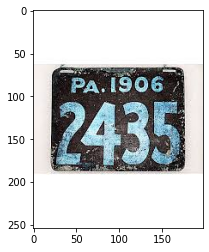

In [7]:
'''
Here we load one of the images to experiment what methods we should use in the
actual implementations of the task
'''

# Original image
im_test = cv2.imread(img_folder+img_names[3], cv2.IMREAD_COLOR)
plt.imshow(im_test)
plt.show()

### Color segmentation

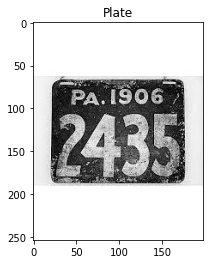

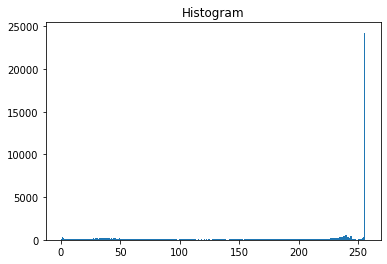

In [8]:
'''
In this cell we convert our image to gray scale, so we can separate the characters
from the background of the image. We ploted a histogram of the pixels, so it is
easier for us to choose a number to use in the threshold function
'''

# Color segmentation
gray = cv2.cvtColor(im_test, cv2.COLOR_RGB2GRAY)

plt.title('Plate')
plt.imshow(gray, cmap='gray')
plt.show()

plt.title('Histogram')
plt.hist(gray.ravel(), 256,[0,256])
plt.show()

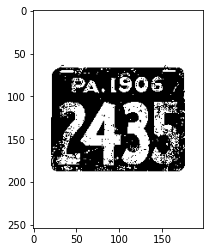

In [9]:
'''
Here we apply threshold to make the image black and white. We use the value
chosen by analysing the hitogram in the cell above 
'''

# Thresholding
_, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(thresh, cmap='gray')
plt.show()

### Filtering

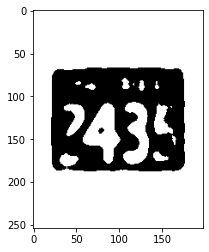

In [10]:
'''
Here we apply a filter to see if it's going to be useful for the
treatment of the image
'''

im_filtered = cv2.medianBlur(thresh,11)
plt.imshow(im_filtered, cmap='gray')
plt.show()

### Morphology

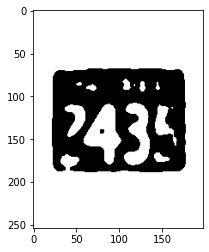

In [11]:
'''
In this cell and below we analyse the use of opening and
closing operations in the image.
'''

# Opening
im_open = morf_opening(im_filtered, np.ones((4,4)))
plt.imshow(im_open, cmap='gray')
plt.show()

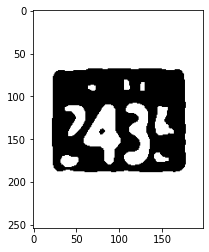

In [12]:
# Closing
im_close = morf_closing(im_filtered, v_line_kernel)
im_close = morf_closing(im_close, cross_kernel)
im_close = morf_closing(im_filtered, np.ones((4,4)))
plt.imshow(im_close, cmap='gray')
plt.show()

### Component segmentation

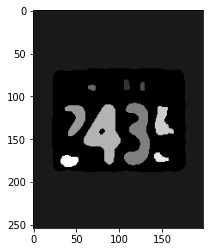

In [13]:
'''
Here we use a function to get the character in the image
'''

# component segmentation
num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(im_close , 4, cv2.CV_32S)
plt.imshow(cc_image,cmap='gray')

106 108 30 73


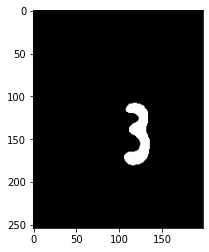

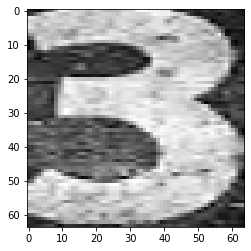

59 110 43 70


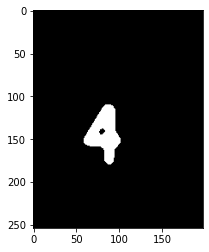

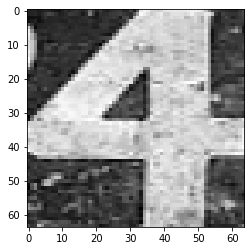

In [14]:
'''
Here we loop through the result we got from the function in the cell above
and we choose a limit for the height of the components we want 
'''

for i in range(num_labels):
  temp = cc_image.copy()
  
  temp[cc_image == i] = 255
  temp[cc_image != i] = 0

  x,y,w,h = stats[i][:4]
  area = stats[i][4]
  cx,cy = centroids[i]
  component = gray[y:y+h, x:x+w]
  component = cv2.resize(component,(64,64))

  if h > 40 and h < 80:
    print(x,y,w,h)
    plt.imshow(temp, cmap='gray')
    plt.show()
    plt.imshow(component, cmap='gray')
    plt.show()

# Actual implementation

## Segmentation

In this section we implemented the funtions to separate charecter from the license plates

In [15]:
def draw_rectangles(im, pos):
  new_im = im
  for p in pos:
    new_im = cv2.rectangle(new_im, (p[0],p[1]), (p[0]+p[2],p[1]+p[3]), (255,0,0), 2)
  return new_im

In [16]:
def segment(img):
  # processing
  im = cv2.imread(img, cv2.IMREAD_COLOR)
  gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
  _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  im_filtered = cv2.medianBlur(thresh,3)
  im_open = morf_opening(im_filtered, np.ones((1,1)))
  num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(im_open , 4 , cv2.CV_32S)
  
  # return
  components_n, components_s, components_l = [], [], []
  for i in range(num_labels):
    x,y,w,h = stats[i][:4]
    area = stats[i][4]
    cx,cy = centroids[i]
    component = gray[y:y+h, x:x+w]
    component = cv2.resize(component,(64,64))

    if h > 70 and h < 104:
      components_n.append([x,y,w,h, component])
    
    if h > 50 and h < 70:
        components_s.append([x,y,w,h, component])

    if h > 104:
      components_l.append([x,y,w,h, component])
    
  components = components_s if len(components_s) > len(components_n) else (components_n if len(components_n) > len(components_l) else components_l)
  recs = [c[:4] for c in components]

  s_img = draw_rectangles(im, recs)

  return components, s_img

0,1,2,4,5,6,9,10 -- funcionou

3,7,8 -- não funcionou

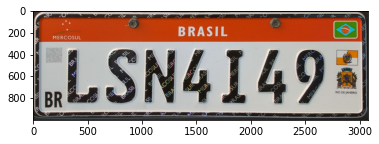

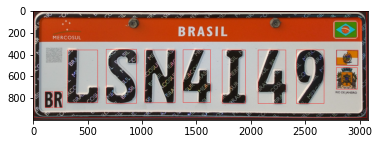

In [17]:
im_name = img_folder+img_names[10]
im = cv2.imread(im_name, cv2.IMREAD_COLOR)
plt.imshow(im)
plt.show()
comps, im_s = segment(im_name)
plt.imshow(im_s)
plt.show()

## Character classification

In this section we try to implement functions that classify the character that we extracted from the lisence plates

# Thoughts and discussion